In [1]:
import os
from glob import glob
import rasterio as rio
import numpy as np
from tqdm import tqdm,tqdm_notebook
from rasterio.plot import reshape_as_image,reshape_as_raster
import re
import pandas as pd
import json
import geopandas as gpd
from rasterio.mask import mask

import seaborn as sns
from rasterio.features import rasterize
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from sklearn.cluster import MiniBatchKMeans
from rasterio.features import sieve
from rasterio.plot import reshape_as_image
from affine import Affine
from skimage.filters import threshold_multiotsu,threshold_otsu,threshold_triangle

def strat_rand_sampling(file,outf,size,nodat=0,seed=None):
    #set seed for numpy random 
    np.random.seed(seed)
    
    data = []
    with rio.open(file) as src:
        
        #translate rows, cols to xy coordinates
        T0 = src.transform
        T1 = T0 * Affine.translation(0.5, 0.5)
        rc2xy = lambda r, c: T1 * (c, r) 

        img = src.read(1)
        strata = np.unique(img)[np.unique(img)!=nodat]
        
        #sample each stratum to a geopanda dataframe
        for stratum in strata: 
            
            rows,cols = np.where(img==stratum)
            idx = np.random.choice(np.arange(len(rows)), size, replace=False)
            stratified_samples = np.array([rc2xy(x, y) for x,y in zip(rows[idx],cols[idx]) ])
            x,y = stratified_samples[:,0],stratified_samples[:,1]
            gdf = gpd.GeoDataFrame(crs=str(src.crs), geometry=gpd.points_from_xy(x,y))
            gdf['class'] = stratum
            data.append(gdf)
    
    data_cat = pd.concat(data,ignore_index=True)
    data_cat.to_file(outf,driver="GeoJSON")
    print(f'Exported as: {outf}')
    
        
def compute_cluster(rws_rgb_img,k=4):
    rws_rgb_img = rws_rgb_img.astype(np.float32)/10000
    samples = reshape_as_image(rws_rgb_img).reshape(-1,rws_rgb_img.shape[0])
    kmeans_pred = MiniBatchKMeans(n_clusters=k+1, random_state=42,max_iter=10,batch_size=10000,reassignment_ratio=0).fit(samples)
    kmeans_pred_img = kmeans_pred.labels_.reshape(rws_rgb_img.shape[1], rws_rgb_img.shape[2]).astype(rio.uint16)
    return kmeans_pred_img

def compute_mnws(img,cluster_img,bands=['B2','B3','B4','B8a','B11','B12']):
    np.seterr(divide='ignore', invalid='ignore')
    
    band_pos = get_arr(bands)
    
    raw_img = img[band_pos]

    mnws = []
    
    max_i = np.argmax(np.unique(cluster_img,return_counts=True)[1])
    all_labels = list(range(0,cluster_img.max()+1))
    labels = list(set(all_labels)-set([all_labels[max_i]]))

    for label in labels:
        
        #calculate band stats
        region_img = np.where(cluster_img==label,raw_img,0)
        band_means = np.array(list(map(lambda x:np.mean(region_img[x][region_img[x]!=0],dtype=np.float32),
                                       range(len(band_pos))))).reshape(len(band_pos),-1)
        band_std = np.array(list(map(lambda x:np.std(region_img[x][region_img[x]!=0],dtype=np.float32),
                                     range(len(band_pos))))).reshape(len(band_pos),-1)
        
        #calculate nws 
        reshaped_raw_img = raw_img.reshape(len(band_pos),-1)
        nws = (((( abs(reshaped_raw_img-band_means) /band_std)**2).sum(0)/len(band_pos))**0.5).reshape(img.shape[1],img.shape[2])
        mnws.append(nws)
        
    mnws_img = np.array(mnws).min(0)

    return mnws_img

def multitemp_clmasks(target_img,reference_img):
    np.seterr(divide='ignore', invalid='ignore')
    
    #cloud shadow = 1 and thick cloud = 2
    db8 = target_img[get_arr('b8')]-reference_img[get_arr('b8a')]
    db11 = target_img[get_arr('b11')]-reference_img[get_arr('b11')]
    db2 = target_img[get_arr('b2')]-reference_img[get_arr('b2')]
    db3 = target_img[get_arr('b3')]-reference_img[get_arr('b3')]
    db4 = target_img[get_arr('b4')]-reference_img[get_arr('b4')]
    b10 = target_img[get_arr('b10')]
    ndvi = compute_index(target_img,'NDVI')
    
    cl_shadow = np.where( (db8<-400) & ( db11< -400 ),1,0)
    cl_thick = np.where( ((db2>800) & (db3 >800) & (db4 >800))|(b10>30) ,2,0)
    forest_sh = np.where(ndvi>0.7,3,0)
   
    cl_masks = np.array([cl_shadow,cl_thick,forest_sh])
    cl_masks = np.amax(cl_masks,axis=0)
    
    return cl_masks
        
def wcf_mnws(mnws_files,invalid_files,thr=3,dec=2):
    
    water_rws_detected = []
    invalid_pixels = []    

    for i in tqdm(range(len(mnws_files)),position=0, leave=True):
        mnws_file = mnws_files[i]
        cl_mask_file = invalid_files[i]

        with rio.open(mnws_file) as src_mnws,rio.open(cl_mask_file ) as src_mask:
            profile = src_mnws.profile.copy()
            mnws_img = src_mnws.read(1)
            cl_mask = src_mask.read(1)

            invalid = np.where(cl_mask==2,1,0)
            invalid_pixels.append(invalid)

            water_rws = np.where((mnws_img<thr)&(mnws_img>0),1,0)
            
            water_rws = np.where( (cl_mask==1) | (cl_mask==3),0,water_rws)
            water_rws_detected.append(water_rws)

    water_rws_detected_sum = np.array(water_rws_detected).sum(0)
    invalid_pixels_sum = np.array(invalid_pixels).sum(0)
    diff_invalid = len(mnws_files)-invalid_pixels_sum

    water_freq_img = np.true_divide(water_rws_detected_sum , diff_invalid, where=(diff_invalid!=0),dtype=np.float32)*12
    water_freq_img_r = np.round(water_freq_img,dec)
    
    return water_freq_img_r,water_rws_detected_sum,profile

#compute non-water pixels
def non_water_mask(mnws_files,thr=3):
    
    water_rws_detected = []
    invalid_pixels = []    

    for i in tqdm(range(len(mnws_files)),position=0, leave=True):
        mnws_file = mnws_files[i]

        with rio.open(mnws_file) as src_mnws:
            profile = src_mnws.profile.copy()
            mnws_img = src_mnws.read(1)

            water_rws = np.where((mnws_img<thr)&(mnws_img>0),1,0)
            water_rws_detected.append(water_rws)

    water_sum = np.array(water_rws_detected).sum(0)
    water_sum = np.where(water_sum==0,1,0)
    water_sum = np.where(mnws_img!=0,water_sum,0)
    return water_sum

def get_arr(bands):
    band_names = ['B2','B3','B4','B5','B6','B7','B8','B8A','B10','B11','B12']
    if isinstance(bands,list):
        return [band_names.index(band.upper()) for band in bands]
    else:
        return band_names.index(bands.upper())
    
def compute_index(arr,name):
    np.seterr(divide='ignore', invalid='ignore')
    
    if name == 'MNDWI':
        b3= arr[get_arr('b3')].astype(np.float32)
        b11 = arr[get_arr('b11')].astype(np.float32)
        index = (b3-b11)/(b3+b11)
        
    elif name == 'MNDVI':
        b5= arr[get_arr('b5')].astype(np.float32)
        b7= arr[get_arr('b7')].astype(np.float32)
        index = (b7-b5)/(b7+b5)
        
    elif name =='NDVI':
        b8= arr[get_arr('b8')].astype(np.float32)
        b4= arr[get_arr('b4')].astype(np.float32)
        index = (b8-b4)/(b8+b4)
        
    elif name =='MGRN':
        index = (arr[get_arr(['b3','b4','b8'])].astype(np.float32)/10000).min(0)
    
    elif name =='AWEI_NSH':
        b3 = arr[get_arr('b3')].astype(np.float32)
        b11 = arr[get_arr('b11')].astype(np.float32)
        b12 = arr[get_arr('b12')].astype(np.float32)
        b8a = arr[get_arr('b8a')].astype(np.float32)
        index = (4*(b3-b11)) -( (0.25*b8a) +(2.75*b12) )
        
    elif name =='AWEI_SH':
        b2 = arr[get_arr('b2')].astype(np.float32)
        b3 = arr[get_arr('b3')].astype(np.float32)
        b11 = arr[get_arr('b11')].astype(np.float32)
        b12 = arr[get_arr('b12')].astype(np.float32)
        b8a = arr[get_arr('b8a')].astype(np.float32)
        index = b2+(2.5*b3)-(1.5*(b8a+b11))-(0.25*b12)
    elif name =='NDMI':
        b8 = arr[get_arr('b8')].astype(np.float32)
        b11 = arr[get_arr('b11')].astype(np.float32)
        index = (b8-b11)/(b8+b11)
    
    return index

def compute_wiw(arr):
    b8a = arr[get_arr('b8a')].astype(np.float32)/10000
    b12 = arr[get_arr('b12')].astype(np.float32)/10000
    return np.where( ((b8a>0)&(b8a<=0.1804)) & ((b12>0)&(b12<=0.1131)), 1, 0)

def compute_rws(arr):
    mndwi = compute_index(arr,'MNDWI')
    mgrn = compute_index(arr,'MGRN')
    
    rws = np.where( (mndwi>threshold_otsu(mndwi[mndwi>0])) &((mgrn>0) & (mgrn<0.15)),1,0)
    rws_img = np.where(rws==1,arr,0)
    
    return rws_img,rws

def get_nbins(water_index):
    iqr = np.subtract(*np.percentile(awei[awei>0], [75, 25]))
    bw = 2*iqr/(len(awei[awei>0])**(1/3))
    return int((awei[awei>0].max()-awei[awei>0].min())/bw)


In [5]:
%%time

#cloud masks computation

#mosaics
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')
dates = [re.findall(r"(\d{8})", file)[0] for file in mosaics]

#reference image 
ref_file = f'{os.path.abspath("..")}results/year_composite_merge.tif'

#open ref composite
with rio.open(ref_file) as src_mask:
    src_profile = src_mask.profile.copy()
    mask = src_mask.read().astype(int)

    #iterate over mosaics, calculate masks and write bands
    for i in tqdm(range(len(mosaics)),position=0, leave=True):
        
        outf = f'{ os.path.abspath("..") }results/invalid_masks/invalid_{dates[i]}.tif'
        
        with rio.open(mosaics[i]) as src:
            profile = src.profile.copy()
            img = src.read()
            
            _,rws = compute_rws(img)
            cl_masks = multitemp_clmasks(img,mask).astype(rio.uint16)
            cl_masks = np.where((img[0]!=src.nodata)&(rws!=1),cl_masks,0).astype(np.int8)
            
            #write to new geotiff
            profile.update({'dtype':cl_masks.dtype,'nodata':0,'count':1})
            with rio.open(outf ,'w',**profile) as dst:
                dst.write_band(1, cl_masks)
                dst.set_band_description(1, f'invalid_{dates[i]}')
            


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [06:18<00:00,  8.41s/it]

Wall time: 6min 20s


In [45]:
%%time

#mnws computation
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')
invalid_masks = glob(f'{os.path.abspath("..")}results/invalid_masks/invalid*.tif')

for i in tqdm(range(len(mosaics)),position=0, leave=True):
    file = mosaics[i]

    outf = f'{os.path.abspath("..")}results/rws_mnws_mndwi_otsu/{os.path.basename(file)}'.replace('mosaic','rws_mnws')
    
    if not os.path.exists(outf):
    
        with rio.open(file) as src, rio.open(invalid_masks[i]) as src_mask:
            profile = src.profile.copy()
            mask = src_mask.read()
            img = src.read()
            img = np.where(img<0,0,img)

            #compute RWS region
            rws_img,_ = compute_rws(img)
            rws_img = np.where(mask>0,0,rws_img)

            #cluster and compute MNWS
            cluster_img = compute_cluster(rws_img[get_arr(['b2','b3','b4'])],8)
            mnws = compute_mnws(img,cluster_img,bands=['B2','B3','B4','B8','B11','B12'])
            mnws = np.where(img[0]==src.nodata,9999,mnws)

            profile.update(nodata=src.nodata,count=1,dtype=mnws.dtype)
            with rio.open(outf,'w',**profile) as dst:
                dst.write_band(1,mnws)

            




100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [37:50<00:00, 50.45s/it]

Wall time: 37min 50s


In [458]:
%%time
#input files

file_mask = list(map(lambda x:x not in [43] ,list(range(45))))

mnws_files = np.array(glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/rws*.tif"))[file_mask]
dates = [re.findall(r"(\d{8})", file)[0] for file in mnws_files]
cl_mask_files = np.array(glob(f"{os.path.abspath('..')}results/invalid_masks/invalid*.tif"))[file_mask]

# #open profile to copy
# with rio.open(mnws_files[0]) as src_0:
#     profile = src_0.profile.copy()
#     profile.update(nodata=0,count=len(mnws_files),dtype=rio.uint16)
    
# #write all detected water to single geotiff
# outf = f"{os.path.abspath('..')}results/water_stack.tif"
# with rio.open(outf,'w',**profile) as dst:
#     for i in tqdm(range(len(mnws_files)),position=0, leave=True):
#         with rio.open(mnws_files[i]) as src:
#             mnws_img = src.read(1)
#             water = np.where((mnws_img<3)&(mnws_img>0),1,0).astype(rio.uint16)

#             dst.write_band(i+1, water)
#             dst.set_band_description(i+1, f'water_{dates[i]}')
            

# water rws frequency  
wf_rws,water_sum,profile = wcf_mnws(mnws_files,cl_mask_files,thr=4,dec=2)

out_wf = f"{os.path.abspath('..')}results/wf_rws.tif"
profile.update({'dtype':wf_rws.dtype,'nodata':0,'count':1})
with rio.open(out_wf,'w',**profile) as dst: dst.write_band(1,wf_rws)
    
out_water_sum = f"{os.path.abspath('..')}results/watersum_rws.tif"
profile.update({'dtype':water_sum.dtype,'nodata':0,'count':1})
with rio.open(out_water_sum,'w',**profile) as dst: dst.write_band(1,water_sum)

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:56<00:00,  1.28s/it]


Wall time: 2min 21s


QGIS expression :
(("wf_rws@1"<=(2/3.5)) AND ("wf_rws@1">0))*1 + (("wf_rws@1">(2/3.5)) AND ("wf_rws@1"<(40/3.5)))*2  + (("wf_rws@1">=(40/3.5)) AND ("wf_rws@1"<=12))*3 + (("wf_rws@1">12))*4 


In [ ]:
#compute non-water pixels from MNWS time-series
#if a pixel satisfy sum(MNWS<3)=0 than its classified as a potential water pixel
#else its a potential non-water pixel

mnws_dir = f'{os.path.abspath("..")}results/rws_mnws_mndwi_otsu/'
mosaics = glob(mnws_dir+"/*mnws*.tif")

mnws_sum = []
for i in tqdm(range(len(mosaics)),position=0, leave=True):
    file = mosaics[i]
    with rio.open(file) as src:
        profile = src.profile.copy()
        mnws_img = src.read(1)
        mnws_img_thr = np.where((mnws_img<3)&(mnws_img>0),1,0)
        mnws_sum.append(mnws_img_thr)
    
mnws_sum = np.array(mnws_sum).sum(0)
mnws_sum = np.where(mnws_sum>0,1,0)


# #export as geotiff
outf = f'{os.path.abspath("..")}results/nonwater_img.tif'
profile.update({'dtype':mnws_sum.dtype,'nodata':0,'count':1})
with rio.open(outf,'w',**profile) as dst:
    dst.write_band(1,mnws_sum)

In [ ]:
# #create stratified random sample
# file = f'{os.path.abspath("..")}results/water_freq_rws_img_v3_classified.tif'
# data  = strat_rand_sampling(file=file,outf='sample.geojson',size=100,nodat=0,seed=42)


In [35]:
def mnws_boxplot(data):
    plt.figure(figsize=(10,5))
    sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
    flierprops = dict(marker='o',markerfacecolor='red', markersize=5,markeredgecolor='white')
    sns.boxplot(data=data,order=['Wa','Sh','Ds','Ve','Ag','Se','Bs','Cl'],flierprops=flierprops,whis=[5, 95],orient='h',palette='husl',linewidth=1)
    plt.xlabel('MNWS',fontsize=16)
    plt.ylabel('Land cover',fontsize=16)
    plt.title('MNWS land cover types 25 Feb 2017 ',fontsize=20)
    plt.xticks(range(0, int(data['Cl'].max()), 5))
    plt.axvline(3, 8,0,ls='--',color='black',lw=2)
    plt.show()

def plot_bands(band_data_mean,band_data_std):
    sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
    plt.figure(figsize=(12,9))
    colors=['blue','orange','brown','yellow','green','purple','red','black']
    axs = [sns.lineplot(data=band_data.loc[band_data.index[i]]/10000,sort=False,color=colors[i]) for i in range(len(band_data.index))]
    axs[0].lines[0].set_linestyle("--")
    plt.legend(band_data.index,loc='upper left',fontsize=16)
    plt.xlabel('Band',fontsize=16)
    plt.ylabel('Surface Reflectance',fontsize=16)
    plt.title('Spectral signature land cover types 25 Feb 2017 ',fontsize=20)


    plt.fill_between(band_names,(band_data.iloc[0]/10000)-(band_data_std.iloc[0]/10000), (band_data.iloc[0]/10000)+(band_data_std.iloc[0]/10000), alpha=.3)
    plt.fill_between(band_names,(band_data.iloc[-1]/10000)-(band_data_std.iloc[-1]/10000), (band_data.iloc[-1]/10000)+(band_data_std.iloc[-1]/10000), alpha=.3,color=colors[-1])

    plt.show()

In [43]:
%%time

# MNWS and band stats example 25 Feb 2017
gdf = gpd.read_file(glob('./data/sample/sample*.geojson')[0])
labels = dict(zip(gdf ['code'].unique(),gdf ['desc'].unique()))
geom_code = list((zip(gdf ['geometry'].tolist(), gdf ['code'].tolist() )))

mosaic = [f for f in glob(f'{os.path.abspath("..")}images/*.tif') if '20170225' in f][0]
mnws = [f for f in glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/*.tif") if '20170225' in f][0]

band_names = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']

with rio.open(mosaic) as src,rio.open(mnws) as src_mnws:

    img = src.read()
#     img = img[get_arr(band_names)]
    img_mnws = src_mnws.read()
    
    sample_mask = rasterize(shapes=geom_code, out_shape=src.shape, transform=src.transform)
    
    #band stats
    band_data = pd.concat([pd.DataFrame(img[:,sample_mask==code].mean(1),columns=[desc]) for code,desc in labels.items()],axis=1).T
    band_data.columns = band_names
    band_data_std = pd.concat([pd.DataFrame(img[:,sample_mask==code].std(1),columns=[desc]) for code,desc in labels.items()],axis=1).T
    band_data_std.columns = band_names
    
    #mnws stats
    mnws_data = pd.concat([pd.DataFrame(img_mnws[:,sample_mask==code]).T for code in list(labels.keys())],axis=1)
    mnws_data.columns = list(labels.values())



Wall time: 5.77 s


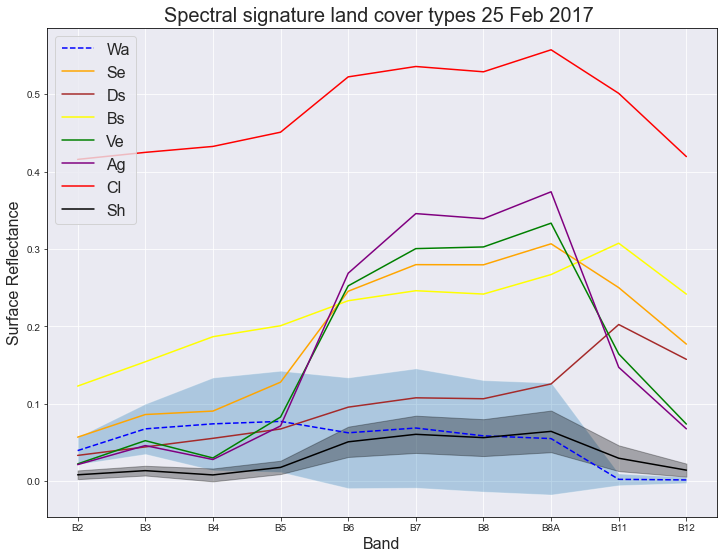

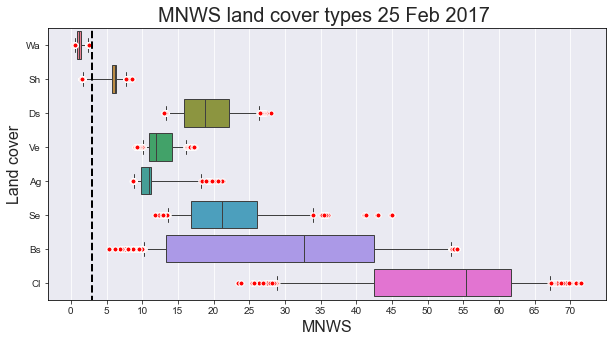

,mean,std,min,max
Wa,1.269,0.528,0.341,2.606
Sh,5.779,1.465,1.382,8.611
Ag,11.675,3.046,8.634,21.259
Ve,12.414,1.878,8.994,17.423
Ds,19.072,4.004,12.985,28.115
Se,22.055,6.485,11.738,45.036
Bs,29.033,15.066,5.311,54.139
Cl,52.118,11.996,23.373,71.446


In [40]:
plot_bands(band_data,band_data_std)
mnws_boxplot(mnws_data)
round(mnws_data.describe(),3).loc[['mean','std','min','max']].T.sort_values('mean')

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 21.76it/s]


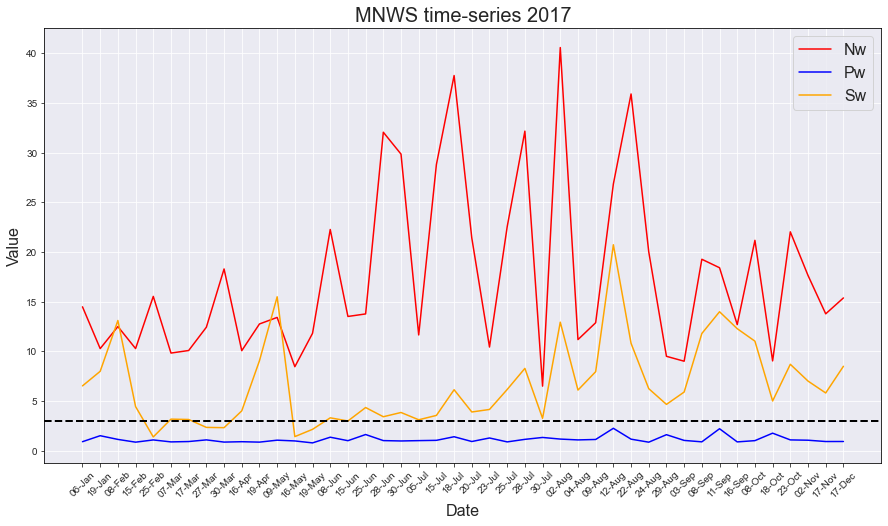

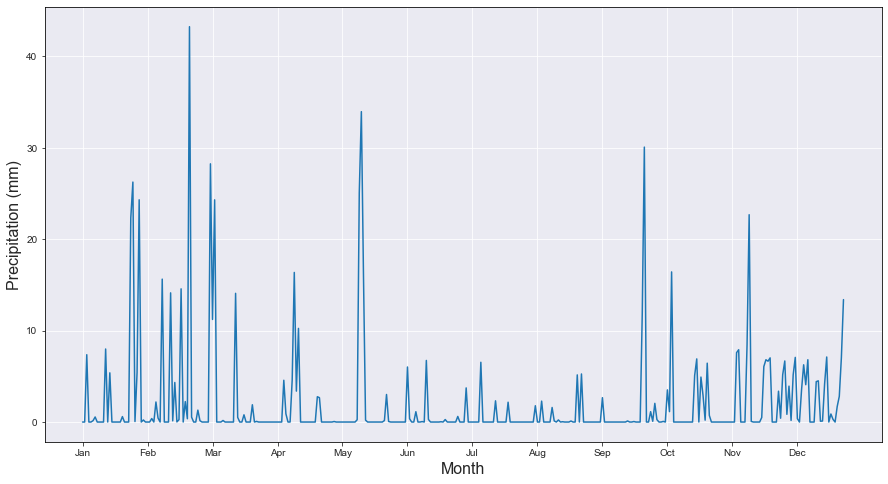

In [447]:
#compute  MNWS time-series
mosaics= glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/*.tif")
ts_sample = glob('./data/sample/ts_sample*.geojson')[0]
geo_ts_sample = gpd.read_file(ts_sample)
coords = list((zip(geo_ts_sample['geometry'].centroid.x,geo_ts_sample['geometry'].centroid.y)))

dates=[]

for i in tqdm(range(len(mosaics)),position=0, leave=True):
    file = mosaics[i]
    date = re.findall(r"(\d{8})", file)[0]
    
    if date !='20171120':
        dates.append(date)
        col_name = str(pd.to_datetime(date).date())

        with rio.open(file) as src:
            #sample mnws time-series
            geo_ts_sample[col_name] = [val[0] for val in src.sample(coords)]
            
geo_ts_sample.iloc[:,4:] = geo_ts_sample.iloc[:,4:].round(3)

plt.figure(figsize=(15,8))
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
ax = sns.lineplot(data=geo_ts_sample.groupby(['desc']).median().T.iloc[2:,:],palette=['red','blue','orange'])
[ax.lines[i].set_linestyle("-") for i in range(3)]
plt.legend(geo_ts_sample.groupby(['desc']).median().T.iloc[2:,:].columns[0:],loc='upper right',fontsize=16)
ax.set_xticklabels(pd.to_datetime(pd.Series(dates)).dt.strftime('%d-%b'))
plt.axhline(3, 8,0,ls='--',color='black',lw=2)
plt.xticks(rotation=45)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Value',fontsize=16)
plt.title('MNWS time-series 2017',fontsize=20)

#rain data
rain_df = pd.read_csv('./data/rain_data.csv',index_col=[0])
rain_df['mm'] = rain_df['mm'].astype(float)

plt.figure(figsize=(15,8))
sns.lineplot(data=rain_df,x='Date',y='mm')
plt.xticks(np.arange(0, len(rain_df),31),labels=pd.to_datetime(rain_df['Date']).dt.strftime('%b')[::31] )

plt.xlabel('Month',fontsize=16)
plt.ylabel('Precipitation (mm)',fontsize=16)


plt.show()